## Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import shap
import polars as pl
import catboost
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import f_oneway
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedKFold
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm  import LinearSVR
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from IPython.core.interactiveshell import InteractiveShell
from explainerdashboard import RegressionExplainer, ExplainerDashboard
from sklearn.model_selection import RepeatedKFold

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Откроем файл и посмотрим с какими данными будем работать.

In [2]:
df = pd.read_csv('../EDA + pipeline/data/abalone.csv')
df

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125           NaN          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera weight  Shell weight  Rings  
0             0.1010        0.1500     15  
1             0.0485        0.0700      7  
2             0.1415        0.2100      9  
3             0.1140        0.1550     10  
4             0.0395        0.0550      7  
...              ...           ...    ...  
4172          0.2390        0.2490     11  
4173          0.2145        0.2605     10  
4174          0.2875        0.3080      9  
4175          0.2610        0.2960     10  
4176          0.3765        0.4950     12  

[4177 rows x 9 columns]

**Описание данных**

**_Признаки_**
- `Sex` - M(мужские), F(женкие) и I (младенцы)
- `Length` - длина в мм(наибольший линейный размер морского ушка)
- `Diameter` - диаметр в мм, перпендикуляр к длине
- `Height` - высота в мм с мякоти
- `Whole weight` - общий вес ушка в граммах
- `Shucked weight` - вес мякоти в граммах
- `Viscera weight` - вес внутренностей в граммах
- `Shell weight` - вес раковины в граммах

**_Целевой признак_**
- `Age` - возраст рассчитывается как rings(число колец) + 1.5

Посмотрим с какими данными придется работать.

In [3]:
df.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125           NaN          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

Только sex является категориальным признаком. Остальные - числянные.
Посмотрим на размер выборки.

In [4]:
df.shape

(4177, 9)

В датасете 4177 объектов. 9 столбцов(8 признаков) и столбец, который отвечает за таргет.
Посмотрим на типы данных и пропуски значений.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Пропуски в столбцах: Diameter, Whole weight и Shell weight.


С помощью describe() посмотрим на основные статистические характеристики данных.

In [6]:
df.describe(include='all')

Sex       Length     Diameter       Height  Whole weight  \
count   4177  4177.000000  4078.000000  4177.000000   4078.000000   
unique     4          NaN          NaN          NaN           NaN   
top        M          NaN          NaN          NaN           NaN   
freq    1447          NaN          NaN          NaN           NaN   
mean     NaN     0.523992     0.407840     0.139516      0.827306   
std      NaN     0.120093     0.099286     0.041827      0.490348   
min      NaN     0.075000     0.055000     0.000000      0.002000   
25%      NaN     0.450000     0.350000     0.115000      0.440500   
50%      NaN     0.545000     0.425000     0.140000      0.798500   
75%      NaN     0.615000     0.480000     0.165000      1.150875   
max      NaN     0.815000     0.650000     1.130000      2.825500   

        Shucked weight  Viscera weight  Shell weight        Rings  
count      4177.000000     4177.000000   4127.000000  4177.000000  
unique             NaN             NaN           NaN          NaN  
top                NaN             NaN           NaN          NaN  
freq               NaN             NaN           NaN          NaN  
mean          0.359367        0.180594      0.239072     9.933684  
std           0.221963        0.109614      0.138942     3.224169  
min           0.001000        0.000500      0.001500     1.000000  
25%           0.186000        0.093500      0.130000     8.000000  
50%           0.336000        0.171000      0.235000     9.000000  
75%           0.502000        0.253000      0.328250    11.000000  
max           1.488000        0.760000      1.005000    29.000000

- В колонке Sex 4 уникальных значения. Большинство ушек мужские.
- В числянных признаках значения уникальны. Нет отрицательных или очень завышенных значений. Значения среднего и медианы схожи.

Проверим данные на бубликаты.

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['sex', 'length', 'diameter', 'height', 'whole weight', 'shucked weight',
       'viscera weight', 'shell weight', 'rings'],
      dtype='object')

Посмотрим матрицы корреляции.

* # Корреляция Pearson

<Axes: >

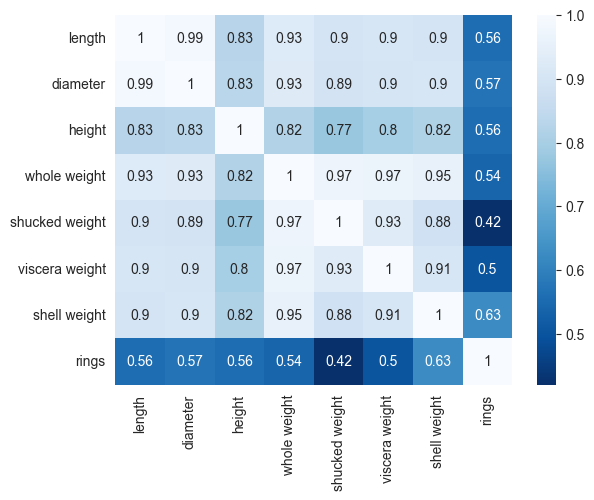

In [9]:

df_num = df.drop('sex', axis=1)
corr = df_num.corr()

sns.heatmap(corr, cmap="Blues_r", annot=True)

* # Корреляция Спирмена

<Axes: >

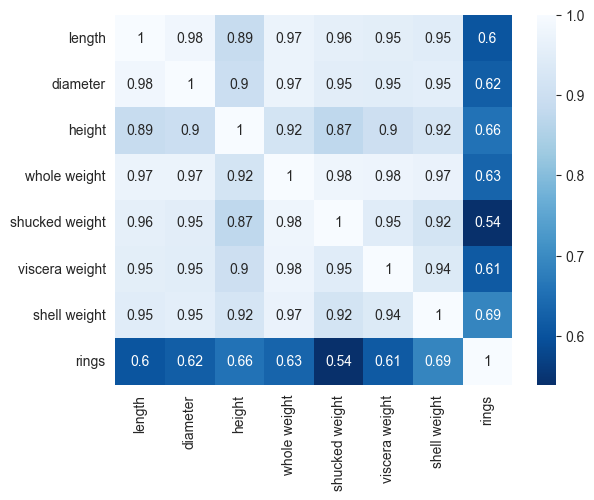

In [10]:
corr = df_num.corr(method='spearman')

sns.heatmap(corr, cmap="Blues_r", annot=True)

* # Корреляция Кэндала

<Axes: >

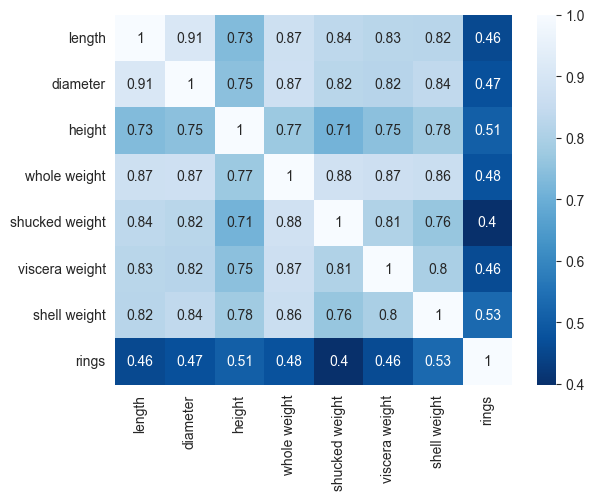

In [11]:
corr = df_num.corr(method='kendall')

sns.heatmap(corr, cmap="Blues_r", annot=True)

Значительной разницы в полученных коэфиициентах корреляции нет.
Наибольшие коэффициент корреляции таргета с весом ушка. А минимальный с весом мякоти.
Другие коэффициенты близки.

Посмотрим на корреляцию между числянными и категориальным признаком(пол) с помощью ANOVA.

In [12]:
Data = []

for c1 in df.columns:
    for c2 in df.columns:
        if df[c1].dtype == 'object' and df[c2].dtype != 'object':
            CategoryGroupLists = df.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No'})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

Category       Numerical Is correlated
0      sex          length           Yes
1      sex        diameter           Yes
2      sex          height           Yes
3      sex    whole weight           Yes
4      sex  shucked weight           Yes
5      sex  viscera weight           Yes
6      sex    shell weight           Yes
7      sex           rings           Yes

Согласно заключению Annova корреляция между полом и физическими размерами и полом есть.

## Rings - кол-во колец

In [13]:
def desc(col):
    print('Description')
    print(df[col].describe())
    print('Value_counts')
    print(df[col].value_counts(dropna=False))
    sns.histplot(data = df[col], kde = True)

Description
count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: rings, dtype: float64
Value_counts
rings
9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: count, dtype: int64


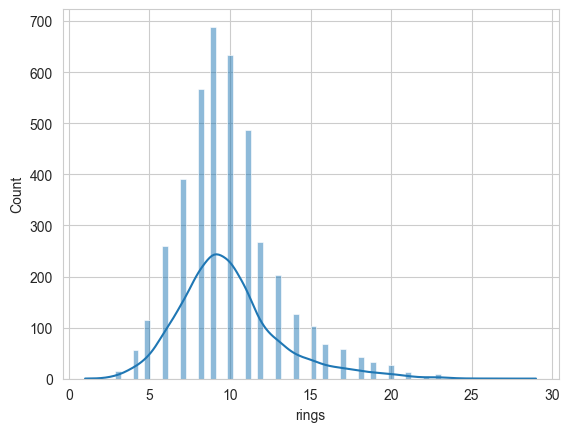

In [14]:
desc('rings')


У нас есть хвост в данных. Он не является очень тяжелым, но може осложнить предсказанием моделей.

Можно попробовать в модель передавать логарифм y вместо y.

<Axes: xlabel='rings', ylabel='Count'>

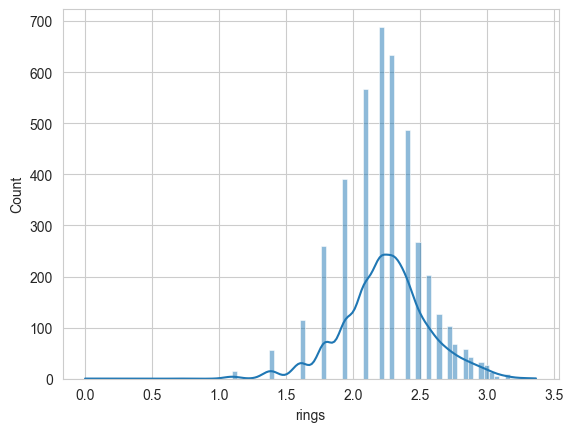

In [15]:
sns.histplot(data = np.log(df['rings']), kde = True)

Рассчитаем таргет согласно указанному в описании датасета(возраст это кол-во колец + 1,5): age = 1.5 + rings

In [16]:
df['age'] = df['rings'] + 1.5

In [17]:
df.head()

sex  length  diameter  height  whole weight  shucked weight  viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125           NaN          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell weight  rings   age  
0         0.150     15  16.5  
1         0.070      7   8.5  
2         0.210      9  10.5  
3         0.155     10  11.5  
4         0.055      7   8.5

## Sex - пол

Description
count     4177
unique       4
top          M
freq      1447
Name: sex, dtype: object
Value_counts
sex
M    1447
I    1276
F    1259
f     195
Name: count, dtype: int64


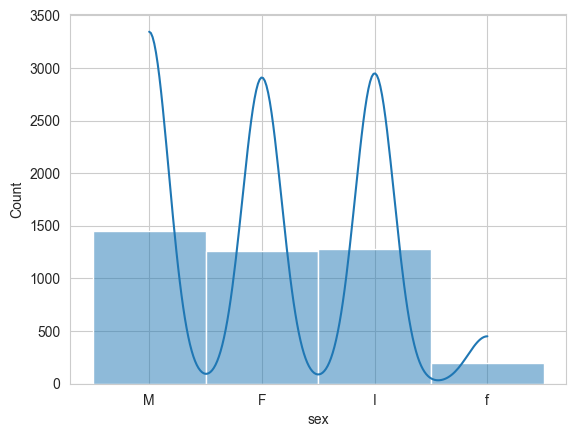

In [18]:
desc('sex')

Переименуем f в F.

In [19]:
df['sex'] = df['sex'].replace({'f' : 'F'})

Description
count     4177
unique       3
top          F
freq      1454
Name: sex, dtype: object
Value_counts
sex
F    1454
M    1447
I    1276
Name: count, dtype: int64


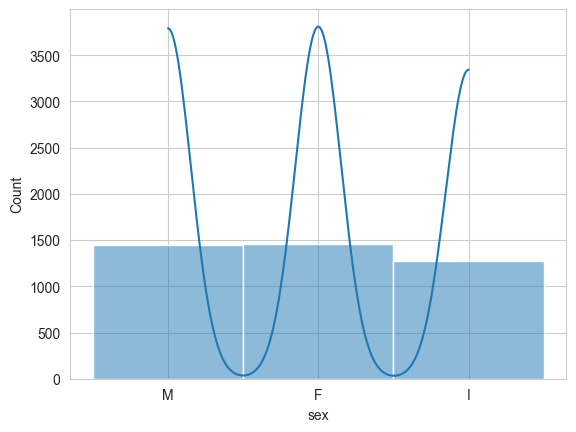

In [20]:
desc('sex')

Кол-во ушек мужского и женского пола примерно равны. Немного меньше ракушек младенцев.

Посмотрим на зависимость среднего возраста от пола ракушек.

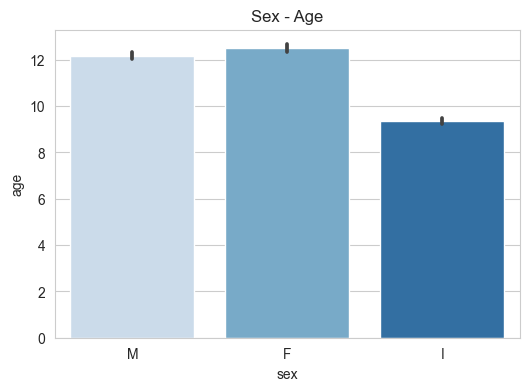

In [21]:
plt.figure(figsize=(6,4))

sns.barplot(x='sex', y='age', data = df, palette='Blues')
plt.title('Sex - Age')
plt.show()


По графику видно, что женские ушки немного тяжелее мужских. Вес ушек младенцев минимален.

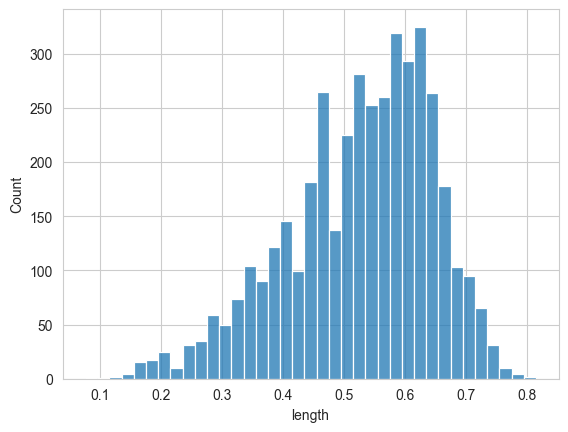

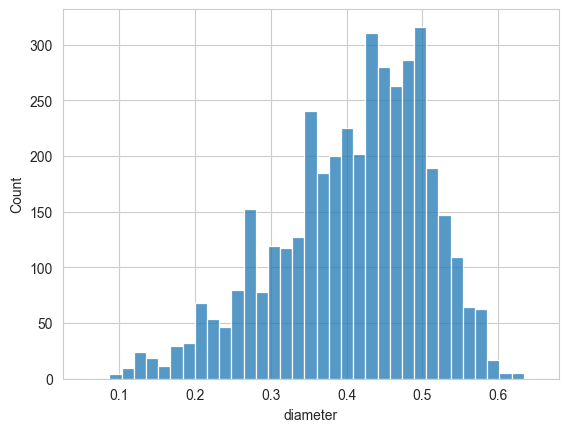

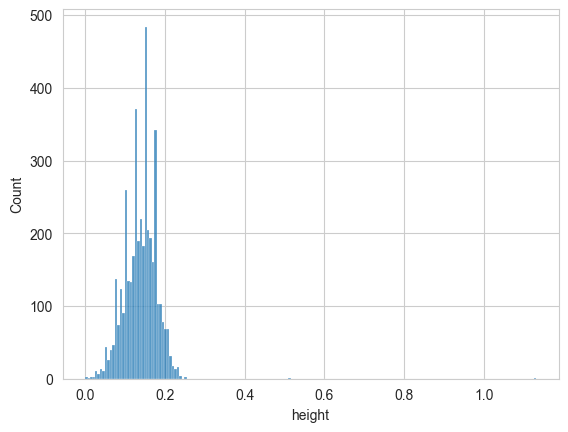

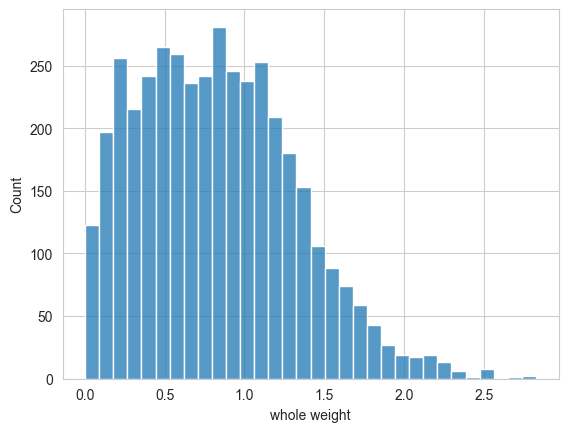

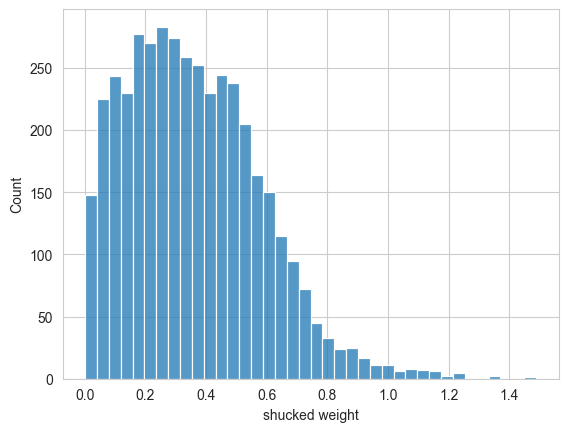

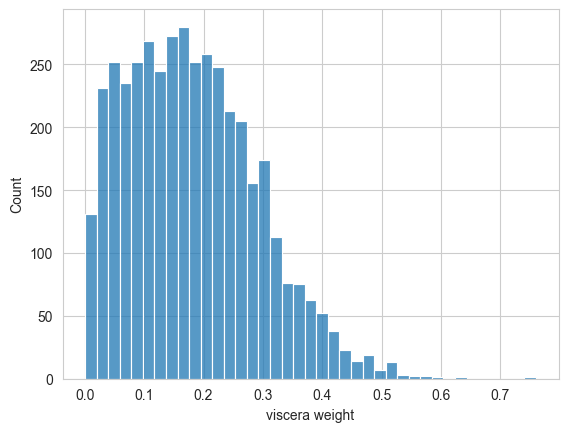

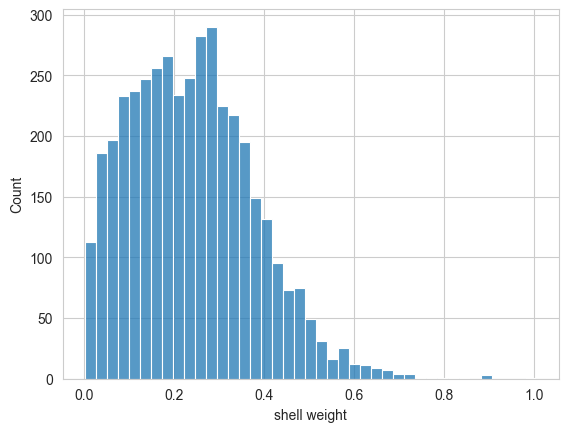

In [22]:
num_cols = [ 'length', 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight']
for c in num_cols:
    sns.histplot(df[c])
    plt.show()

Посмотрим на зависимость среднего веса от длины, диаметра, высоты, общего веса, веса мякоти, веса внутренностей,веса ракушки.

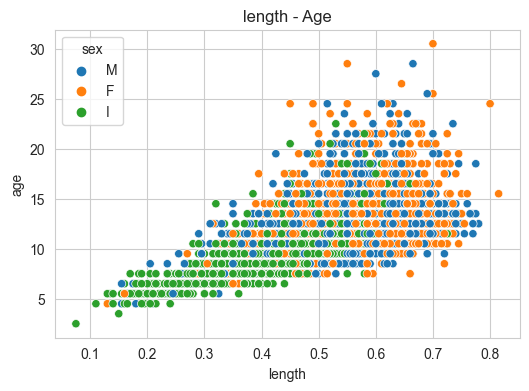

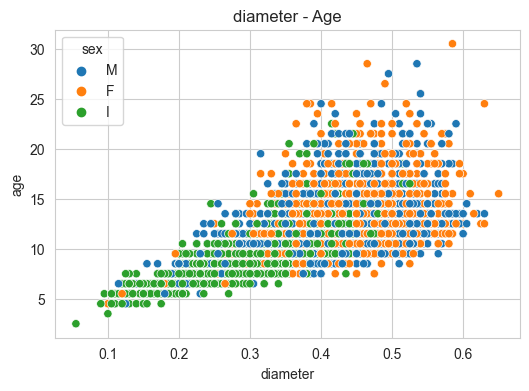

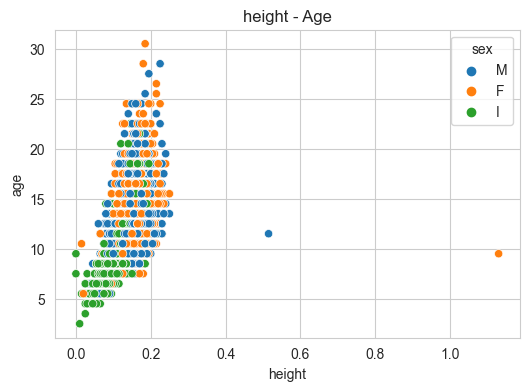

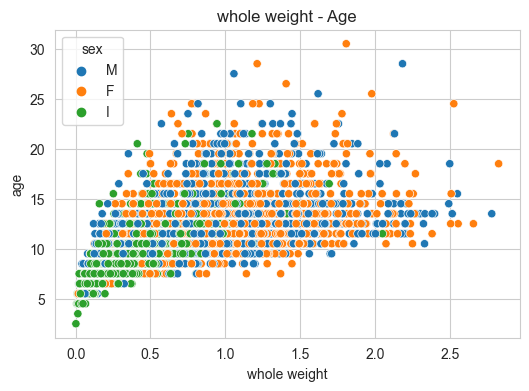

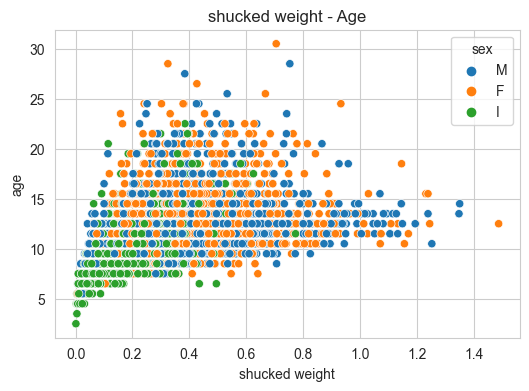

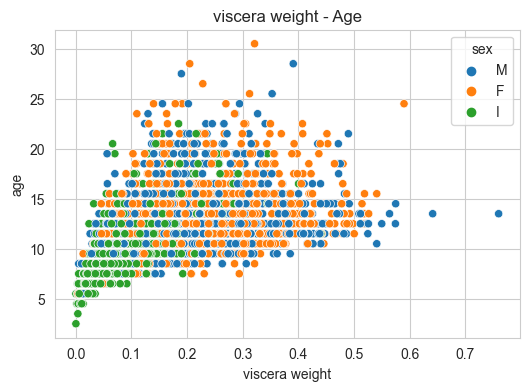

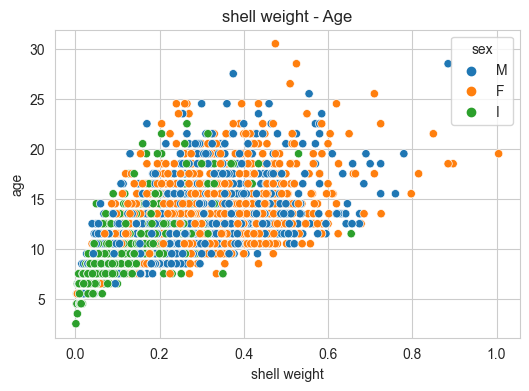

In [23]:
num_cols = [ 'length', 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight']
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=c, y="age", hue="sex")
    plt.title(f'{c} - Age')
    plt.show()

Согласно всем графикам, минимальные размеры и вес относятся к ракушкам-младенцам. Значительной разницы между мужскими и женскими ракушками не наблюдается.

<Axes: >

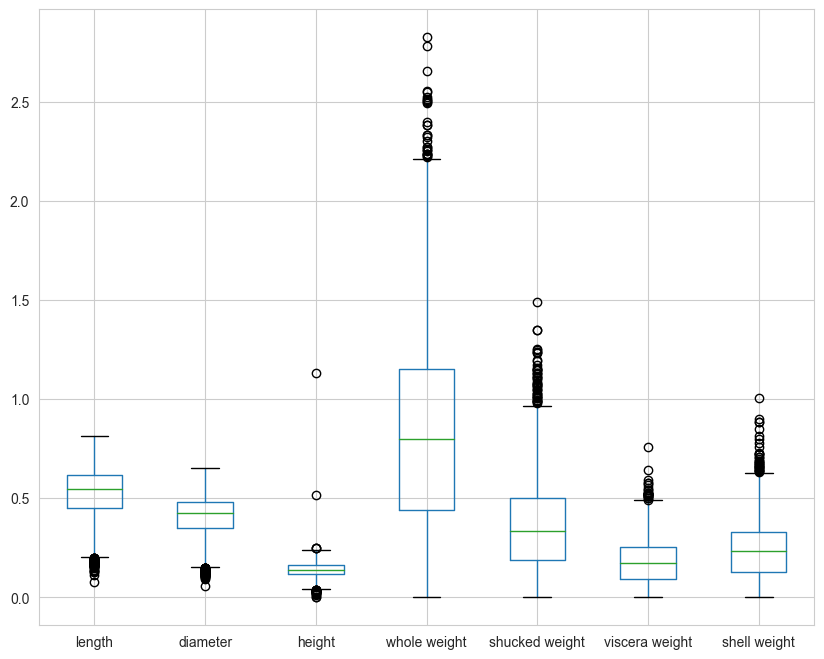

In [24]:
plt.figure(figsize=(10, 8))
df[num_cols].boxplot()

У нас есть выбросы в общем весе, весе мякоти, внутренностей и весе раковин.

c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight


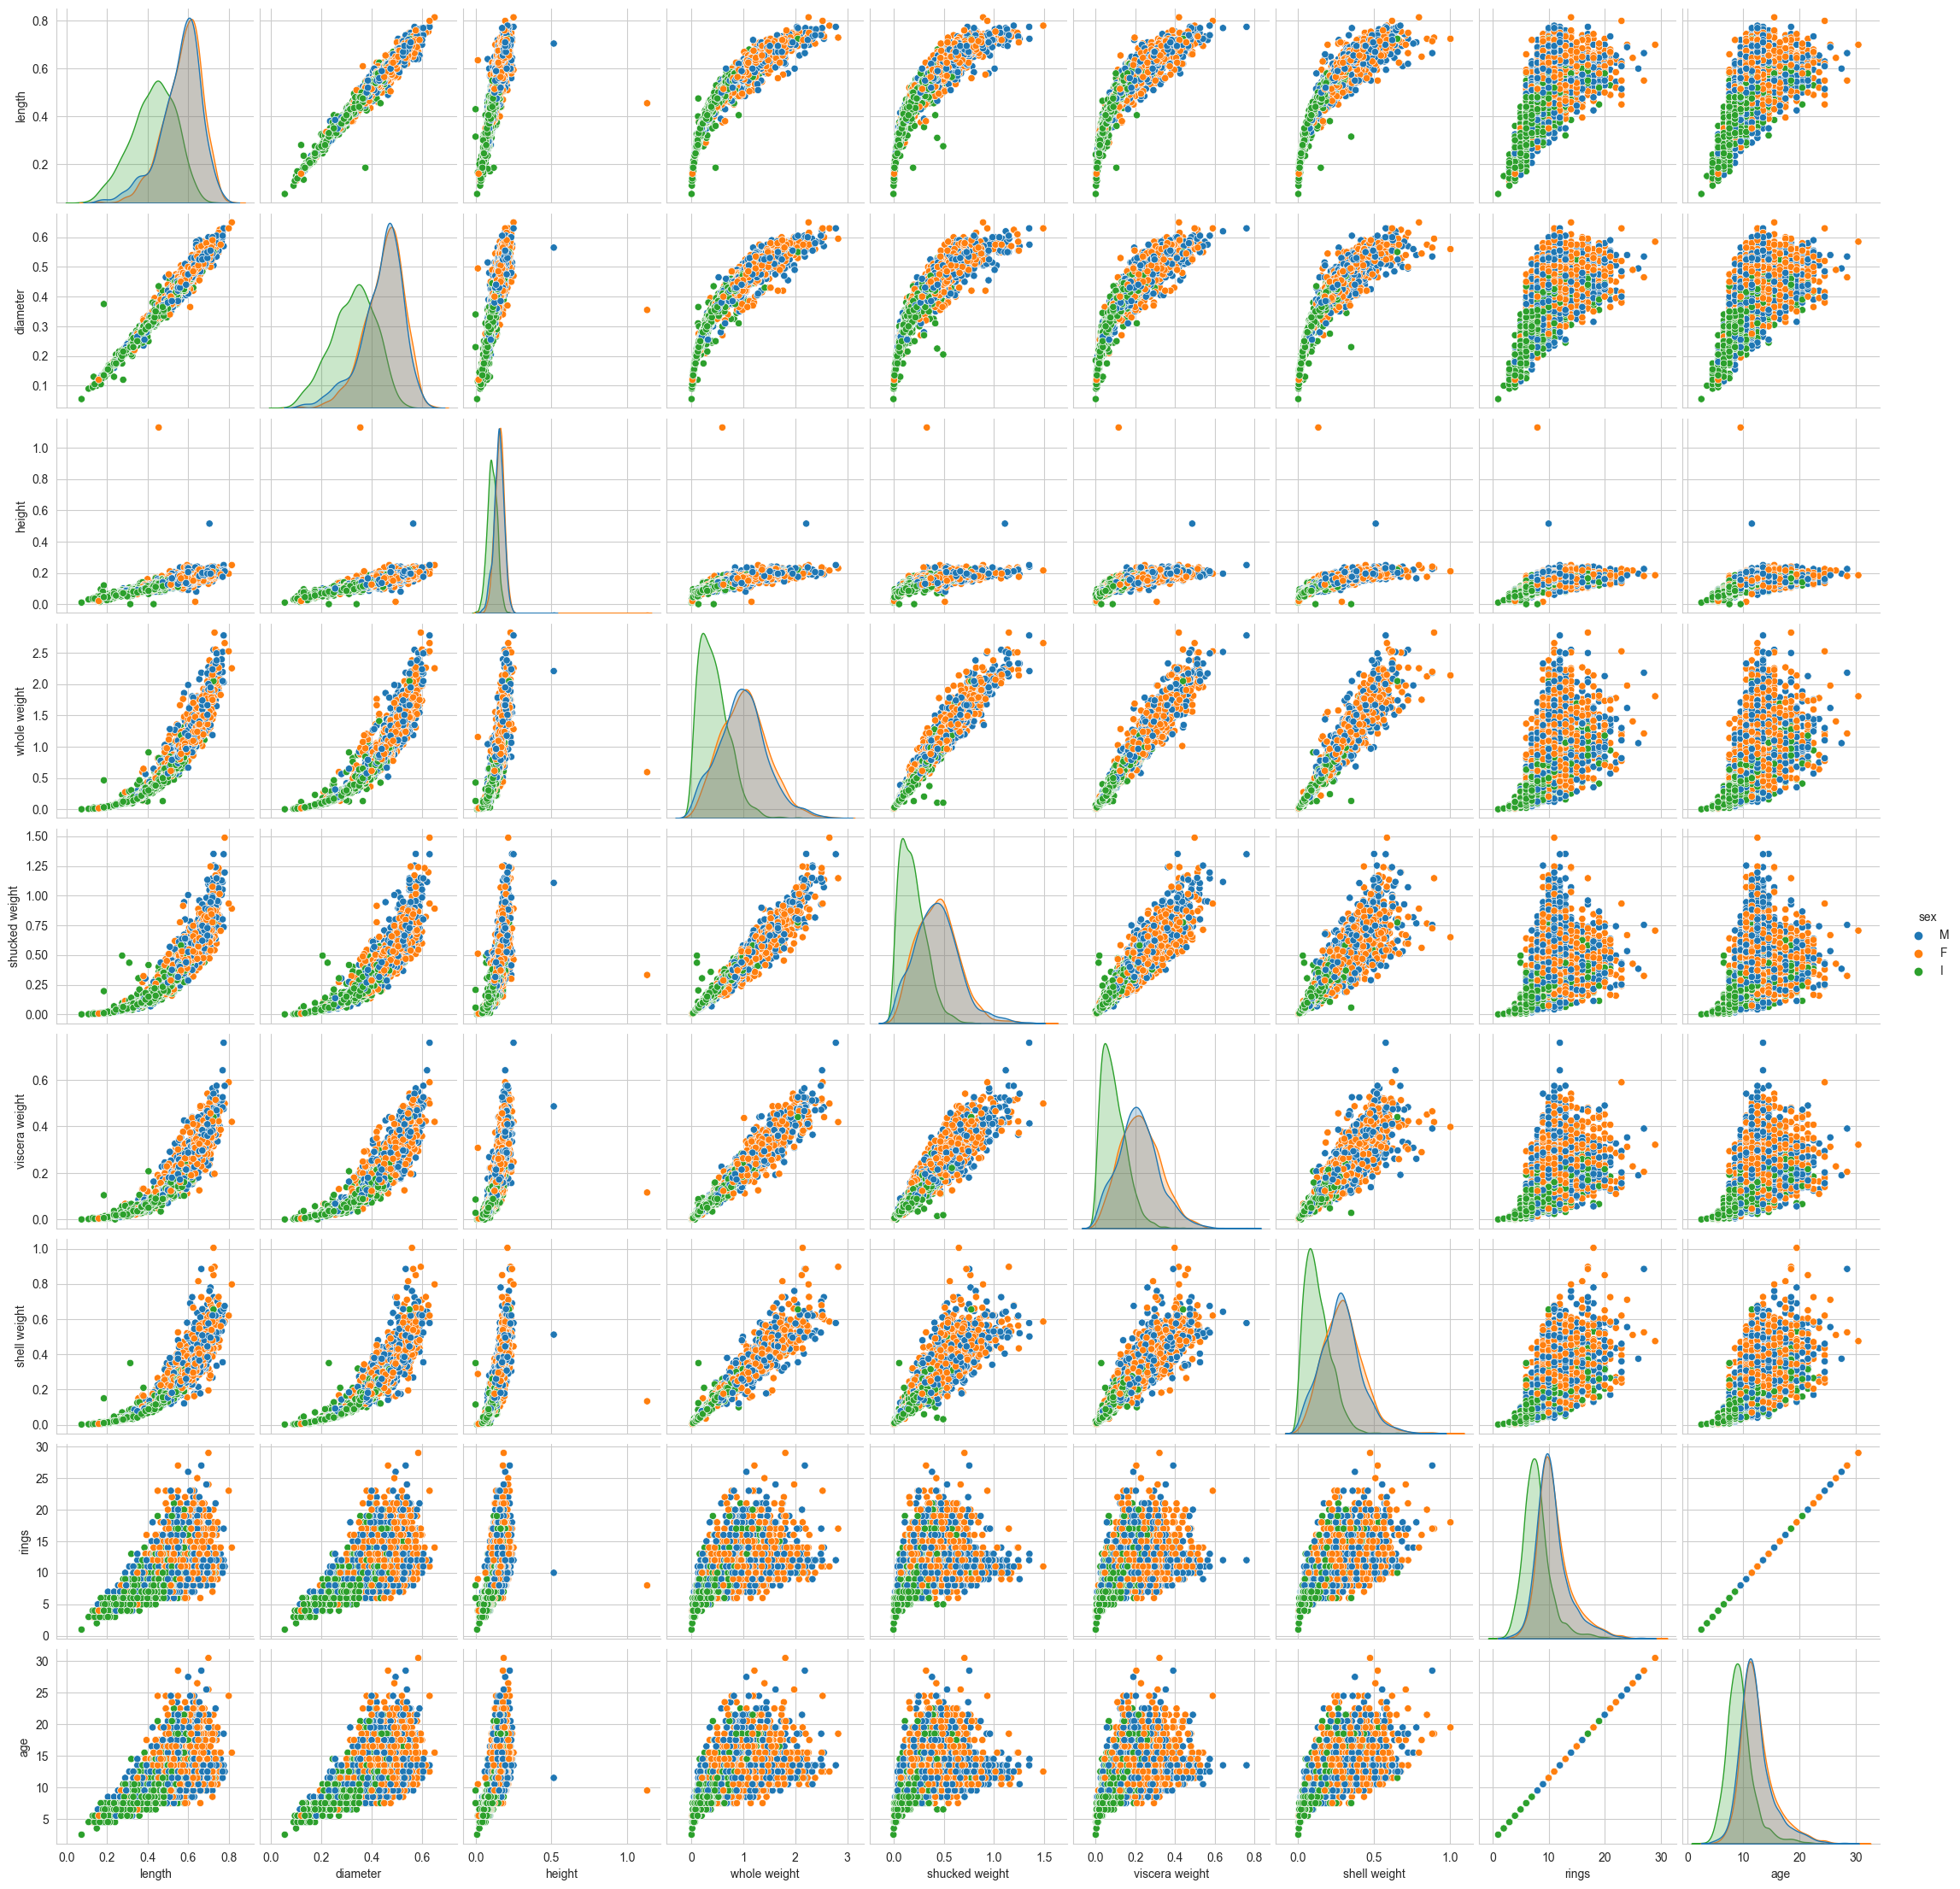

In [25]:
sns.pairplot(df, hue="sex")

По pairplot видно, что минимальные размеры и вес относятся к ракушкам-младенцам. Значительной разницы между мужскими и женскими ракушками не наблюдается.

## Upsampling датасета

Зададим функцию, которая будет увеличивать кол-во строк до минимального. Передаем на вход dataframe, который нужно размножить и размер датасета, который мы должны получить на выходе.

In [26]:
def upsample(data,rows):
    data = shuffle(data, random_state=12345)
    repeat = math.ceil(rows/len(data))
    data = pd.concat([data]*repeat, ignore_index=True)
    data = shuffle(data, random_state=12345)
    data = data[:rows]
    return data

In [27]:
df_mln = upsample(df, 1000000)
len(df_mln)

1000000

## Сравнение работы Pandas vs Polars

* Загрузка данных

In [28]:
%%time
#Polaris
df_pl = pl.read_csv('../EDA + pipeline/data/abalone.csv')

CPU times: total: 46.9 ms
Wall time: 10.6 ms


In [29]:
%%time
# Pandas
df_p = pd.read_csv('../EDA + pipeline/data/abalone.csv')

CPU times: total: 15.6 ms
Wall time: 13.9 ms


Polaris работает быстрее с загрузкой.

* Фильтрация

In [30]:
%%time
# Polars
df_pl[['Sex', 'Rings']]

CPU times: total: 0 ns
Wall time: 0 ns


shape: (4_177, 2)
┌─────┬───────┐
│ Sex ┆ Rings │
│ --- ┆ ---   │
│ str ┆ i64   │
╞═════╪═══════╡
│ M   ┆ 15    │
│ M   ┆ 7     │
│ F   ┆ 9     │
│ M   ┆ 10    │
│ …   ┆ …     │
│ M   ┆ 10    │
│ M   ┆ 9     │
│ F   ┆ 10    │
│ M   ┆ 12    │
└─────┴───────┘

In [31]:
%%time
# Pandas
df_p[['Sex', 'Rings']]

CPU times: total: 0 ns
Wall time: 2 ms


Sex  Rings
0      M     15
1      M      7
2      F      9
3      M     10
4      I      7
...   ..    ...
4172   F     11
4173   M     10
4174   M      9
4175   F     10
4176   M     12

[4177 rows x 2 columns]

In [32]:
%%time
# Pandas
df_p[(df_p.Sex == 'M') & (df_p.Rings > 10)]

CPU times: total: 0 ns
Wall time: 3.38 ms


Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
12     M   0.490     0.380   0.135        0.5415          0.2175   
15     M   0.500     0.400   0.130        0.6645          0.2580   
20     M   0.355     0.280   0.095        0.2455          0.0955   
27     M   0.590     0.445   0.140        0.9310          0.3560   
...   ..     ...       ...     ...           ...             ...   
4144   M   0.670     0.535   0.190        1.6690          0.7465   
4145   M   0.670     0.525   0.200        1.7405          0.6205   
4147   M   0.695     0.550   0.195        1.6645          0.7270   
4148   M   0.770     0.605   0.175        2.0505          0.8005   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera weight  Shell weight  Rings  
0             0.1010         0.150     15  
12            0.0950         0.190     11  
15            0.1330         0.240     12  
20            0.0620         0.075     11  
27            0.2340         0.280     12  
...              ...           ...    ...  
4144          0.2935         0.508     11  
4145          0.2970         0.657     11  
4147          0.3600         0.445     11  
4148          0.5260         0.355     11  
4176          0.3765         0.495     12  

[620 rows x 9 columns]

In [33]:
%%time
# Polars
df_pl.filter((pl.col('Sex') == 'M') & (pl.col('Rings') > 10))

CPU times: total: 0 ns
Wall time: 33.4 ms


shape: (620, 9)
┌─────┬────────┬──────────┬────────┬───┬────────────────┬────────────────┬──────────────┬───────┐
│ Sex ┆ Length ┆ Diameter ┆ Height ┆ … ┆ Shucked weight ┆ Viscera weight ┆ Shell weight ┆ Rings │
│ --- ┆ ---    ┆ ---      ┆ ---    ┆   ┆ ---            ┆ ---            ┆ ---          ┆ ---   │
│ str ┆ f64    ┆ f64      ┆ f64    ┆   ┆ f64            ┆ f64            ┆ f64          ┆ i64   │
╞═════╪════════╪══════════╪════════╪═══╪════════════════╪════════════════╪══════════════╪═══════╡
│ M   ┆ 0.455  ┆ 0.365    ┆ 0.095  ┆ … ┆ 0.2245         ┆ 0.101          ┆ 0.15         ┆ 15    │
│ M   ┆ 0.49   ┆ 0.38     ┆ 0.135  ┆ … ┆ 0.2175         ┆ 0.095          ┆ 0.19         ┆ 11    │
│ M   ┆ 0.5    ┆ 0.4      ┆ 0.13   ┆ … ┆ 0.258          ┆ 0.133          ┆ 0.24         ┆ 12    │
│ M   ┆ 0.355  ┆ 0.28     ┆ 0.095  ┆ … ┆ 0.0955         ┆ 0.062          ┆ 0.075        ┆ 11    │
│ …   ┆ …      ┆ …        ┆ …      ┆ … ┆ …              ┆ …              ┆ …            ┆ …     │
│ M   ┆ 0.67   ┆ 0.525    ┆ 0.2    ┆ … ┆ 0.6205         ┆ 0.297          ┆ 0.657        ┆ 11    │
│ M   ┆ 0.695  ┆ 0.55     ┆ 0.195  ┆ … ┆ 0.727          ┆ 0.36           ┆ 0.445        ┆ 11    │
│ M   ┆ 0.77   ┆ 0.605    ┆ 0.175  ┆ … ┆ 0.8005         ┆ 0.526          ┆ 0.355        ┆ 11    │
│ M   ┆ 0.71   ┆ 0.555    ┆ 0.195  ┆ … ┆ 0.9455         ┆ 0.3765         ┆ 0.495        ┆ 12    │
└─────┴────────┴──────────┴────────┴───┴────────────────┴────────────────┴──────────────┴───────┘

Polaris опять выигрывает в фильтрации.

* Агрегация данных

In [34]:
%%time
# Pandas
df_p.groupby('Sex').agg({'Whole weight' : 'mean', 'Diameter' : 'max'})

CPU times: total: 0 ns
Wall time: 4 ms


Whole weight  Diameter
Sex                        
F        1.043791      0.65
I        0.430636      0.55
M        0.982599      0.63
f        0.886241      0.60

In [35]:
%%time
# Polars
df_pl.groupby('Sex').agg([pl.mean('Whole weight'), pl.max('Diameter')])

CPU times: total: 46.9 ms
Wall time: 20.8 ms


shape: (4, 3)
┌─────┬──────────────┬──────────┐
│ Sex ┆ Whole weight ┆ Diameter │
│ --- ┆ ---          ┆ ---      │
│ str ┆ f64          ┆ f64      │
╞═════╪══════════════╪══════════╡
│ I   ┆ 0.430636     ┆ 0.55     │
│ f   ┆ 0.886241     ┆ 0.6      │
│ F   ┆ 1.043791     ┆ 0.65     │
│ M   ┆ 0.982599     ┆ 0.63     │
└─────┴──────────────┴──────────┘

In [36]:
%%time
# lazy operations
q = (
    df_pl
    .lazy()
    .groupby(by='Sex')
    .agg(
        [
            pl.col('Whole weight').mean(),
            pl.col('Diameter').max()
        ]
    )
)

q.collect()

CPU times: total: 31.2 ms
Wall time: 17.9 ms


shape: (4, 3)
┌─────┬──────────────┬──────────┐
│ Sex ┆ Whole weight ┆ Diameter │
│ --- ┆ ---          ┆ ---      │
│ str ┆ f64          ┆ f64      │
╞═════╪══════════════╪══════════╡
│ I   ┆ 0.430636     ┆ 0.55     │
│ F   ┆ 1.043791     ┆ 0.65     │
│ f   ┆ 0.886241     ┆ 0.6      │
│ M   ┆ 0.982599     ┆ 0.63     │
└─────┴──────────────┴──────────┘

Polaris быстрее в агрегации, но lazy operations медленнее чем агригация по схожему с pandas способу.

## ## Построение baseline

* закодируем категориальные признаки при помощи TargetEncoder(у нас такой только sex)
* масштабируем все признаки с помощью StandardScaler
* обучим линейную регрессию

Разделим данные на таргет y и матрицу признак X.

In [37]:
X = df.drop(['age','rings'], axis=1)
y = df['age']

Посмотрим на пропуски в данных.

In [38]:
X.isna().sum()

sex                0
length             0
diameter          99
height             0
whole weight      99
shucked weight     0
viscera weight     0
shell weight      50
dtype: int64

Заполним пропуски медианным значением.

In [39]:
for c in ['diameter','whole weight','shell weight']:
    X[c] = X[c].fillna(X[c].median())

Проверим как сработало заполнение.

In [40]:
X.isna().sum()

sex               0
length            0
diameter          0
height            0
whole weight      0
shucked weight    0
viscera weight    0
shell weight      0
dtype: int64

Пропусков нет. Разделим данные на тестовую и тренировочныую выборки.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=911)

Сохраним в список категориальный столбец sex - cat_features и числовые столбцы в num_features.

In [42]:
cat_features = ['sex']
num_features = ['length', 'diameter', 'height', 'whole weight', 'shucked weight','viscera weight', 'shell weight']

Оформляем в pipeline этапы работы с данными,  а также модель для обучения.
Запускаем обучение и предсказываем возраст ушек для тестовой выборки.
Считаем метрику RMSE.

* Запуск на числовых признаках.

In [43]:
p1_num = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])
p1_num.fit(X_train[num_features], y_train)
pred = p1_num.predict(X_test[num_features])
score_rmse_p1_num = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE {}".format(round(score_rmse_p1_num, 2)))

RMSE 2.35


* Запуск на числовых + категориальный признак.

In [44]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_features)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])
p1.fit(X_train, y_train)
pred = p1.predict(X_test)
score_rmse_p1 = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE {}".format(round(score_rmse_p1, 2)))

RMSE 2.32


**Вывод по добавлению категориального признака:**  При добавлении категориального признака sex метрика ухудшилась на 0,03.

Попробуем вместо у подать на логарифм y, избавившить от хвоста в распределении.
Обучим модель на том же пайплайне и сравним полученные метрики.

* Запуск на числовых признаках.

In [45]:
y_train_l = np.log(y_train)
y_test_l = np.log(y_test)
p1_num.fit(X_train[num_features], y_train_l)
pred = p1_num.predict(X_test[num_features])
score_rmse_p1_l_num = np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(pred)))
print("RMSE {}".format(round(score_rmse_p1_l_num, 2)))

RMSE 3.59


* Запуск на числовых + категориальный признак.

In [46]:
p1.fit(X_train, y_train_l)
pred = p1.predict(X_test)
score_rmse_p1_l = np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(pred)))
print("RMSE {}".format(round(score_rmse_p1_l, 2)))


RMSE 3.26


**Вывод по логарифмированию таргета:** метрики модели улучшились, как при запуске обучении только на числянных признаках. Так и при добавлении категориального.


А сейчас мы попробуем разные модели, чтобы выбрать лучшую, по которой будем осуществлять настройку точных параметров модели. Запускать будем на всех признаках(категориальный + числовые).

* Запуск на числовых признаках.

In [47]:
list_pipelines_ = []
mean_score_ = []
models = [
    KNeighborsRegressor(),
    LinearSVR(random_state=911),
    DecisionTreeRegressor(random_state=911),
    RandomForestRegressor(random_state=911),
    AdaBoostRegressor(random_state=911),
    GradientBoostingRegressor(random_state=911),
    CatBoostRegressor(random_seed=911,  verbose=False),
    lgb.LGBMRegressor(random_state=911),
    xgb.XGBRegressor(seed=911)
    ]
scalers = [StandardScaler()]

for m in models:
    for scaler in scalers:
        p2 = Pipeline([
             ('scaler_', scaler),
              ('model_', m)
              ])
        scores_ = cross_val_score(p2, X[num_features], y, scoring = 'neg_root_mean_squared_error')
        print(scaler)
        print(m)
        print("model score: %.3f" % scores_.mean())
        print()
        mean_score_.append(scores_.mean())
        list_pipelines_.append(str(m) + str(scaler))

StandardScaler()
KNeighborsRegressor()
model score: -2.333


c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `

StandardScaler()
LinearSVR(random_state=911)
model score: -2.346

StandardScaler()
DecisionTreeRegressor(random_state=911)
model score: -3.083
StandardScaler()
RandomForestRegressor(random_state=911)
model score: -2.211
StandardScaler()
AdaBoostRegressor(random_state=911)
model score: -2.908
StandardScaler()
GradientBoostingRegressor(random_state=911)
model score: -2.196
StandardScaler()
model score: -2.191
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.065400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

Посмотрим на результаты. Постоим график и запишем их в dataframe.

0
KNeighborsRegressor()StandardScaler()              -2.333301
LinearSVR(random_state=911)StandardScaler()        -2.346141
DecisionTreeRegressor(random_state=911)Standard... -3.082674
RandomForestRegressor(random_state=911)Standard... -2.211121
AdaBoostRegressor(random_state=911)StandardScal... -2.908082
GradientBoostingRegressor(random_state=911)Stan... -2.195856
<catboost.core.CatBoostRegressor object at 0x00... -2.190982
LGBMRegressor(random_state=911)StandardScaler()    -2.220685
XGBRegressor(base_score=None, booster=None, cal... -2.320563

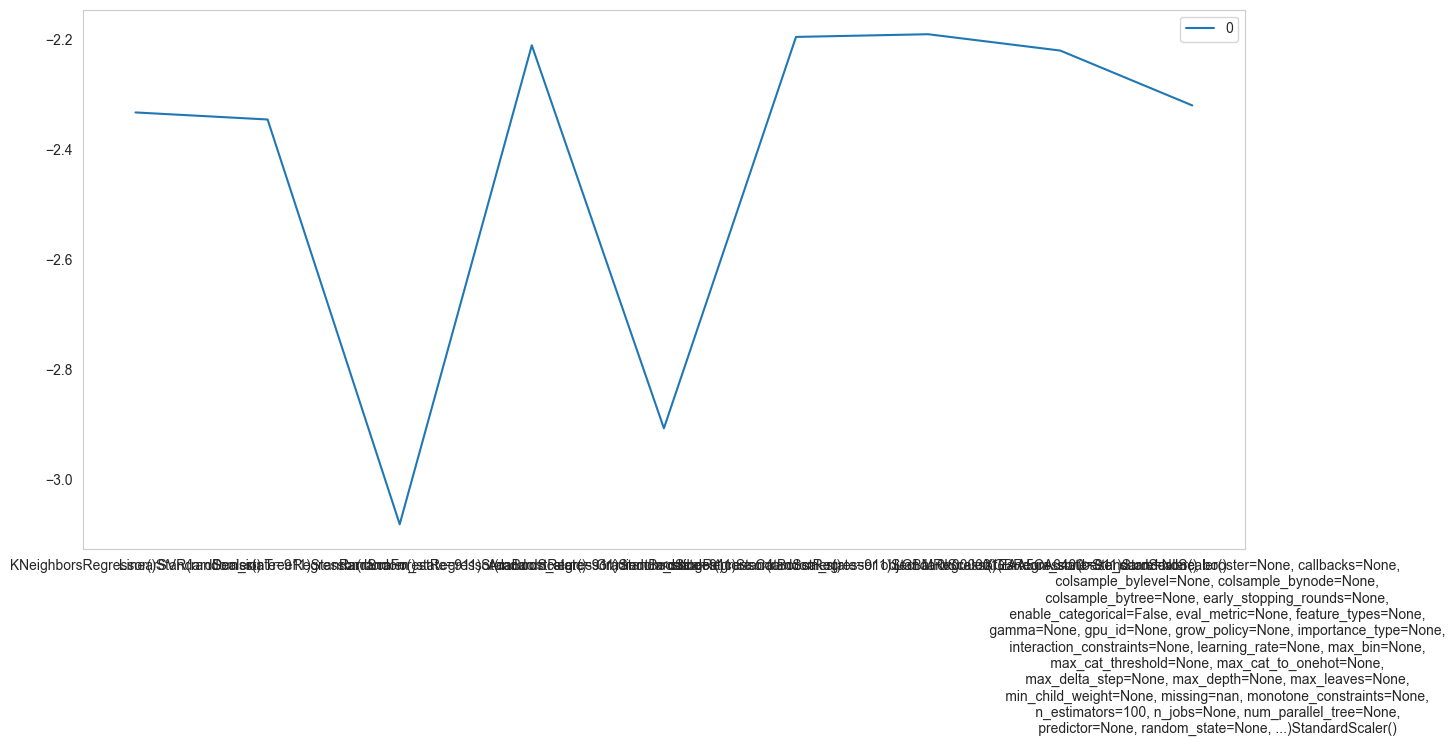

In [48]:
results_num=pd.DataFrame(data=mean_score_,index=list_pipelines_)
results_num.plot(figsize=(15,7))
plt.grid()
results_num

In [49]:
max_value = max(mean_score_)
max_index = mean_score_. index(max_value)
results_num.iloc[max_index]

0   -2.190982
Name: <catboost.core.CatBoostRegressor object at 0x000001EAA5CA6400>StandardScaler(), dtype: float64

**Вывод по подбору для числянных данных** лучший score 2.19 получила модель CatBoostRegressor.

* Запуск на числовых + категориальный признак.

In [50]:
list_pipelines_ = []
mean_score_ = []
models = [
    KNeighborsRegressor(),
    LinearSVR(random_state=911),
    DecisionTreeRegressor(random_state=911),
    RandomForestRegressor(random_state=911),
    AdaBoostRegressor(random_state=911),
    GradientBoostingRegressor(random_state=911),
    CatBoostRegressor(random_seed=911,  verbose=False),
    lgb.LGBMRegressor(random_state=911),
    xgb.XGBRegressor(seed=911)
    ]
scalers = [StandardScaler()]

for m in models:
    for scaler in scalers:
        p2 = Pipeline([
            ('encoder_',TargetEncoder(cols=cat_features)),
             ('scaler_', scaler),
              ('model_', m)
              ])
        scores_ = cross_val_score(p2, X, y, scoring = 'neg_root_mean_squared_error')
        print(scaler)
        print(m)
        print("model score: %.3f" % scores_.mean())
        print()
        mean_score_.append(scores_.mean())
        list_pipelines_.append(str(m) + str(scaler))

StandardScaler()
KNeighborsRegressor()
model score: -2.292


c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
c:\users\optimus prime\pycharmprojects\pythonproject\eda\eda + pipeline\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `

StandardScaler()
LinearSVR(random_state=911)
model score: -2.319
StandardScaler()
DecisionTreeRegressor(random_state=911)
model score: -3.020
StandardScaler()
RandomForestRegressor(random_state=911)
model score: -2.204
StandardScaler()
AdaBoostRegressor(random_state=911)
model score: -2.952
StandardScaler()
GradientBoostingRegressor(random_state=911)
model score: -2.168
StandardScaler()
model score: -2.170

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1295
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 8
[LightGBM] [Info] Start training from score 11.065400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the

Посмотрим на результаты. Постоим график и запишем их в dataframe.

0
KNeighborsRegressor()StandardScaler()              -2.291896
LinearSVR(random_state=911)StandardScaler()        -2.319213
DecisionTreeRegressor(random_state=911)Standard... -3.020098
RandomForestRegressor(random_state=911)Standard... -2.203914
AdaBoostRegressor(random_state=911)StandardScal... -2.952047
GradientBoostingRegressor(random_state=911)Stan... -2.168158
<catboost.core.CatBoostRegressor object at 0x00... -2.169717
LGBMRegressor(random_state=911)StandardScaler()    -2.198284
XGBRegressor(base_score=None, booster=None, cal... -2.304323

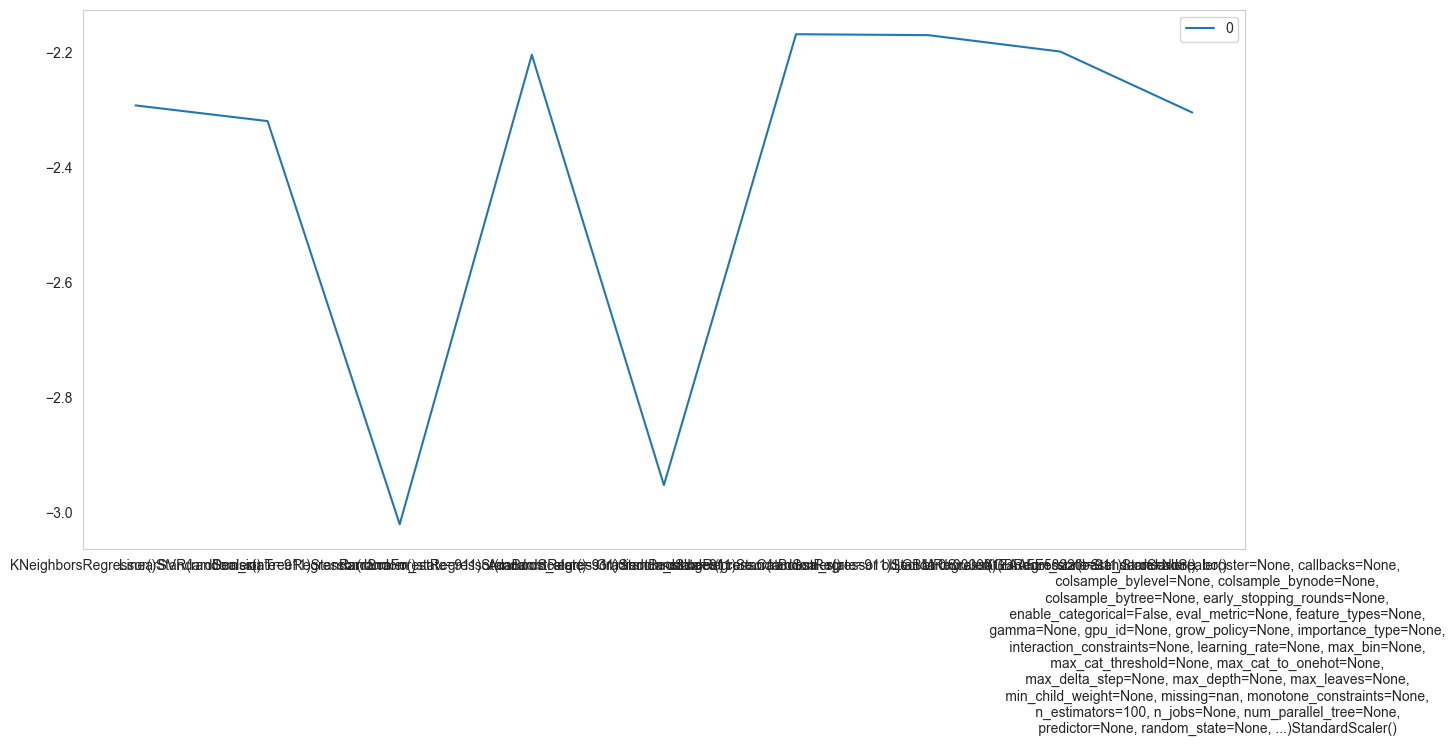

In [51]:
results=pd.DataFrame(data=mean_score_,index=list_pipelines_)
results.plot(figsize=(15,7))
plt.grid()
results

In [52]:
max_value = max(mean_score_)
max_index = mean_score_. index(max_value)
results.iloc[max_index]

0   -2.168158
Name: GradientBoostingRegressor(random_state=911)StandardScaler(), dtype: float64

**Вывод по подбору модели (числянные + категориальный признак) ** лучший score уменьшился и составил 2.17. Модель GradientBoostingRegressor.

Посмотрим на метрики пока без подбора гипер-параметров.
* Запуск на числовых признаках. Модель CatBoostRegressor.

In [53]:
p2_num = Pipeline([
     ('scaler_', StandardScaler()),
      ('model', CatBoostRegressor(random_seed=911,  verbose=False))
       ])
p2_num.fit(X_train[num_features], y_train)
y_pred = p2_num.predict(X_test[num_features])
score_rmse_p2_num = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE {}".format(round(score_rmse_p2_num, 2)))

RMSE 2.18


* Запуск на числовых + категориальный признак. GradientBoostingRegressor.

In [54]:
p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_features)),
     ('scaler_', StandardScaler()),
      ('model', GradientBoostingRegressor(random_state=911))
       ])
p2.fit(X_train, y_train)
y_pred = p2.predict(X_test)
score_rmse_p2 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE {}".format(round(score_rmse_p2, 2)))

RMSE 2.13


**Выбор по подбору модели только для числяннх и с категориальным признаков** модели выбираются разные. Но качество у лучшей модели с категориальным признаком выше, чем без него.

* Запуск на числовых признаках. Модели LinearRegression и CatBoostRegressor.

In [55]:
print(f"RMSE {round(score_rmse_p1_num,2), round(score_rmse_p2_num,2)}")

RMSE (2.35, 2.18)


**Запуск с категориальным признаком:** Сравним метрики, полученные с помощью LinearRegression и GradientBoostingRegressor.

In [56]:
print(f"RMSE{round(score_rmse_p1,2),round(score_rmse_p2,2)}")

RMSE(2.32, 2.13)


**Вывод по запуску лучшей модели:**
Ошибки при запуске на всех признаках уменьшились. Подобранные модели дают лучшие метрики в сравнении с LinearRegression.

Сделаем подбор гипер-параметров моделей.

* Запуск на числянных характеристиках.

In [57]:
p3_num = Pipeline([
     ('scaler_', StandardScaler()),
      ('model', GradientBoostingRegressor())
       ])
param_grid = {'model__n_estimators' : [ 50, 100, 500, 1000],
              'model__learning_rate':  [ 0.01, 0.02, 0.03],
              'model__subsample': [0.5, 0.7],
              'model__max_depth': [7, 10, 15]
              }
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(p3_num, param_grid=param_grid, n_jobs=-1, cv=cv)
grid.fit(X_train[num_features], y_train)
model = grid.best_estimator_
y_pred = model.predict(X_test[num_features])

In [58]:
grid.best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 7,
 'model__n_estimators': 500,
 'model__subsample': 0.7}

In [59]:
score_rmse_p3_num = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE {}".format(round(score_rmse_p3_num, 2)))

RMSE 2.14


* Запуск на числянных + категориальном признаках.

In [60]:
p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_features)),
     ('scaler_', StandardScaler()),
      ('model', GradientBoostingRegressor())
       ])
param_grid = {'model__n_estimators' : [ 50, 100, 500, 1000],
              'model__learning_rate':  [ 0.01, 0.02, 0.03],
              'model__subsample': [0.5, 0.7],
              'model__max_depth': [7, 10, 15]
              }
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(p4, param_grid=param_grid, n_jobs=-1, cv=cv)
grid.fit(X_train, y_train)
model = grid.best_estimator_
y_pred = model.predict(X_test)

In [61]:
grid.best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 7,
 'model__n_estimators': 500,
 'model__subsample': 0.5}

In [62]:
score_rmse_p4 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE {}".format(round(score_rmse_p4, 2)))

RMSE 2.11


Сравним ошибки при обучении только на числовых признаках.

In [63]:
print(f"RMSE {score_rmse_p1_num,score_rmse_p2_num,score_rmse_p3_num}")

RMSE (2.353058365983017, 2.1826617859955135, 2.1415819124764606)


**Вывод** Ошибка постепенно снижается.

Посмотрим ошибки на всех признаках(категориальный + числовые):

In [64]:
print(f"RMSE {score_rmse_p1, score_rmse_p2, score_rmse_p4}")

RMSE (2.31648375891676, 2.127228826175499, 2.1107470347297115)


**Вывод** ошибка постепенно снижается.

Посмотрим на среднее значение по таргету.

In [65]:
np.mean(y)

11.433684462532918

Сравним ошибку со средним по таргету.

In [66]:
np.sqrt(mean_squared_error(y_test, y_pred))/y.mean()

0.18460777377987175

<Axes: xlabel='age', ylabel='Count'>

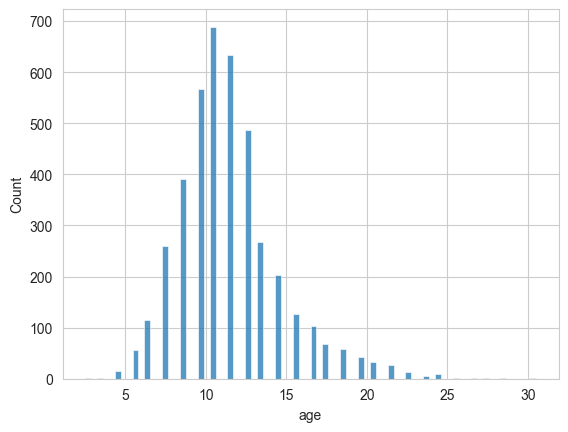

In [67]:
sns.histplot(df['age'])

Посмотрим на RMSE с возрастом более 20 лет и менее 5 летю Сравним их.

In [72]:
print(np.sqrt(mean_squared_error(y_test[y_test>20], y_pred[y_test>20])))
np.sqrt(mean_squared_error(y_test[y_test>20], y_pred[y_test>20]))/y.mean()

6.591735105063462


0.5765188926337736

In [74]:
print(np.sqrt(mean_squared_error(y_test[y_test<5], y_pred[y_test<5])))
np.sqrt(mean_squared_error(y_test[y_test<5], y_pred[y_test<5]))/y.mean()

1.6313818257688333


0.14268207515387663

Вывод по ошибке модели: % ошибки RMSE выше для данных с таргетом более 20 лет.

### Shapley values

Посмотрим на то, как работает модель с помощю метода shapley библиотеки shap.    
Наша модель:

In [75]:
grid.best_estimator_

Pipeline(steps=[('encoder_', TargetEncoder(cols=['sex'])),
                ('scaler_', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=7,
                                           n_estimators=500, subsample=0.5))])

Подгтовим значения. Проведем кодирование и масштабирование.

In [76]:
explainer = shap.TreeExplainer(grid.best_estimator_['model'])
observations = grid.best_estimator_['encoder_'].transform(X)
observations = grid.best_estimator_['scaler_'].transform(observations)
shap_values = explainer.shap_values(observations)

Построим summary_plot, чтобы оценить какие признаки модель считает самыми важными.

In [69]:
print(f"The Root Mean Squared Error of our Model is {score_rmse_p1,score_rmse_p2,score_rmse_p4}")

The Mean Absolute Error of our Model (1.5996382688759354, 1.5086543078011114, 1.511637449552582)
The Root Mean Squared Error of our Model is (1.2647680692031782, 1.228272896306481, 1.2294866609900987)
The Mean Absolute Percentage Error of our Model is (0.13831527654544834, 0.1294673457398911, 0.1300218548343571)


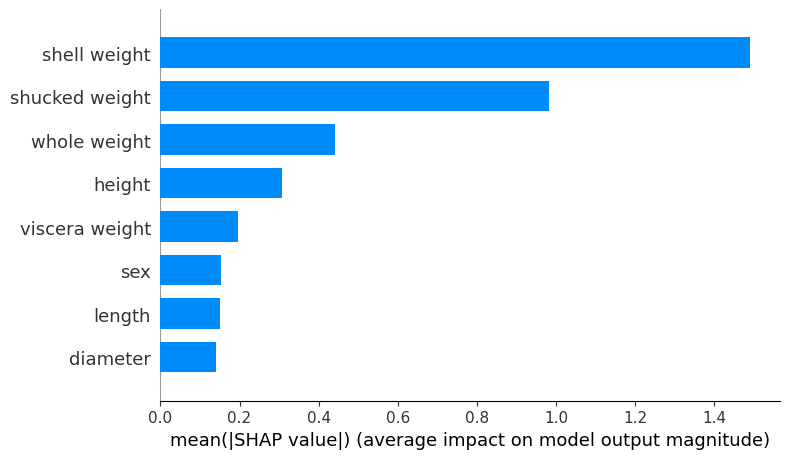

In [77]:
shap.summary_plot(shap_values, X, plot_type="bar")

Наиболее важным признаком явлется вес ракушки.Немного меньший по важности вес мякоти. А общий вес только на 3тьем мести по важности.    
Наименее важными признаками, с примерно идентичным значениием, являются пол, диаметр и длина.     
Немного важнее - высота ушка и вес внутренностей.

Выходит, что вес является более важным признаком для модели, чем геометрические размеры моллюска.

Посмотрим на то, в какую сторону сдвигается прогноз модели по признакам ушка.

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:699: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


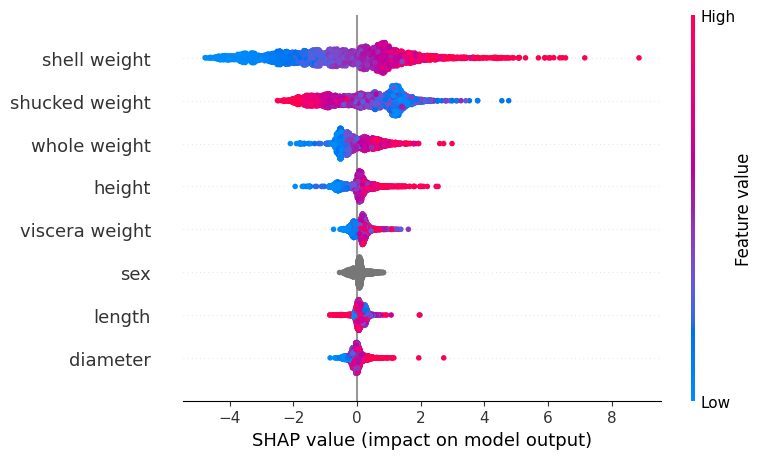

In [78]:
shap.summary_plot(shap_values, X)

По графику видно, что лишь 2 признака имеют обратную зависимость от таргета. Это длина и вес внутренностей. Чем больше это значение, тем меньше возраст. Хотя, по длине не все так однозначно.    
Остальные признаки с увеличением значения приводят у увеличению таргета.    
Получается, что увеличение общего веса, вес ракушки, диаметра и общего веса молюска трактуется моделью как больший возраст.     
Чем меньше эти параметры, тем больший возраст объекта.

# Explainer Dashboard    

Посмотрим на Explainer Dashboard модели.

In [79]:
InteractiveShell.ast_node_interactivity = "all"

In [80]:
explainer = RegressionExplainer(grid.best_estimator_, X_test.iloc[:1000], y_test.iloc[:1000])

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [81]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [82]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>

Анализ модели по Explainer Dashboard:
* Наиболее важными являются вес ракушки, вес мякоти и общий вес малюска. Геометрические размеры объекта значительно меньше влияют на предсказание возраста молюска.
* Получены следующие метрики модели:

root-mean-squared-error	2.129
R-squared	0.543

 RMSE 2.129. Средний таргет 11 лет, что достаточно неплохо. Но мы выяснили, что процент ошибки на ушках с возрастом более 20 лет ниже, чем на ушках с возрастом до 5 лет. При этом МАЕ, конечно выше для данных с таргетом более 20 лет.

# Посмотрим на индивидуальные предсказания на объектах:

## 1033
Предсказанный возраст 	14.196
Действительный возраст 	11.500
Ошибка в предсказании составила -2.696

Самое серьезное влияние +2.06 дал вес ракушки, +0.9 общий вес, +0.39 от веса внутренностей, +0,23 от высоты, +0.19 из-за значения длины. А вот снижение по предсказанию -1.12 от веса мякоти.

Average of population	11.44
shell weight = 1.7033046533016487	+2.06
shucked weight = 1.372389388881187	-1.12
whole weight = 1.6296489632512492	+0.9
viscera weight = 1.283575752929552	+0.39
height = 1.1653076523168566	+0.23
length = 1.043833131192708	+0.19
diameter = 1.1825569894735501	+0.06
sex = 0.540320309811879	+0.05
Other features combined	+0.0
Final prediction	14.2


## 1825
Предсказанный возраст 	6.307
Действительный возраст 	5.500
Ошибка в предсказании составила -0.807

Самое сильное снижение от среднего -4.18 из-за значения shell weight, а вот наибольшее увеличение дал вес мякоти +1.08.

Average of population	11.44   
shell weight = -1.5932666786287848	-4.18
shucked weight = -1.5109484853365958	+1.08
whole weight = -1.5868805913763395	-0.59
height = -2.1577534466979302	-0.51
viscera weight = -1.5224083467071905	-0.37
diameter = -2.321000937690811	-0.33
length = -2.363836883875753	-0.13
sex = -1.5035336596519364	-0.12
Other features combined	+0.0
Final prediction	6.31

 ## 3130
Предсказанный возраст 	12.173
Действительный возраст 	12.500  
Ошибка в предсказании составила 	0.327

Самое сильное снижение от среднего -0.83 из-за значения веса мякоти, + 0.67 от веса ракушки, +0.39 от диаметра, +0.33 от общего веса.

Average of population	11.44
shucked weight = 0.7493904878216506	-0.83
shell weight = 0.5469909617094926	+0.67
diameter = 1.0810045857876265	+0.39
whole weight = 0.7087338625487444	+0.33
viscera weight = 0.9435938345567637	+0.2
length = 1.210060936805804	-0.19
height = 0.654067483237659	+0.14
sex = 0.540320309811879	+0.03
Other features combined	+0.0
Final prediction	12.17


## ELI5

In [83]:
import eli5

In [85]:
X_train_transformed = grid.best_estimator_['encoder_'].transform(X_train)
X_train_transformed = grid.best_estimator_['scaler_'].transform(X_train_transformed)
X_train.shape, X_train_transformed.shape

((3132, 8), (3132, 8))

In [88]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)

In [89]:
perm = eli5.sklearn.PermutationImportance(grid.best_estimator_, random_state=42).\
    fit(X_train_transformed.iloc[:1000], y_train.iloc[:1000])

eli5.show_weights(perm, feature_names = X_train_transformed.columns.tolist())Shucked weight